<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/us_prod_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchvision
!pip install torchaudio
!pip install wordcloud
!pip install TextBlob
!pip install spacy
!pip install textstat
!pip install pyldavis
!pip install flair
!pip install transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import os
import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pyLDAvis
import collections
from nltk.stem import PorterStemmer
import gensim
import re
import pyLDAvis.gensim_models as gensimvis
nltk.download('punkt')
nltk.download('wordnet')
#from keybert import KeyBERT
import spacy
import plotly.express as px
import string
from nltk.tokenize import sent_tokenize
from flair.data import Sentence
from flair.nn import Classifier
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.api as sms

pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def get_sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

#sentiment_pipeline = pipeline("sentiment-analysis")
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

'''
def sentiment(text):
    try:
        return sentiment_pipeline(subset)['label'],  sentiment_pipeline(subset)['score']
    except:
        -99, -99
'''

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def plot_dist(df, col):
    sns.distplot(df[col], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

def get_sentiment_raw(review_text):
    sentence = Sentence(review_text)

    # load the NER tagger
    tagger = Classifier.load('sentiment')

    # run NER over sentence
    tagger.predict(sentence)

    return str(sentence)

def get_sentiment_val(review_text):
    sentence = Sentence(review_text)

    # load the NER tagger
    tagger = Classifier.load('sentiment')

    # run NER over sentence
    tagger.predict(sentence)

    return str(sentence).split(" → ")[1].split(" ")[0]

def get_sentiment_score(review_text):
    sentence = Sentence(review_text)

    # load the NER tagger
    tagger = Classifier.load('sentiment')

    # run NER over sentence
    tagger.predict(sentence)

    return float(str(sentence).split(" → ")[1].split(" ")[1].replace("(","").replace(")",""))


In [4]:
df_review = pd.read_csv("review.csv")
df_review['REVIEW_TEXT'] = df_review['REVIEW_TEXT'].apply(lambda x : str(x))
df_review['REVIEW_TEXT'] = df_review['REVIEW_TEXT'].apply(lambda x : x.strip())
df_review['REVIEW_TEXT_LEN'] = df_review['REVIEW_TEXT'].apply(lambda x : len(str(x)))
print(df_review.shape)
df_review.head()

(331271, 6)


,BRAND,REVIEW_TEXT,REGIONLANGUAGE,PRODUCTRATING,PRODUCTREVIEWCOUNT,REVIEW_TEXT_LEN
0,baseus,"Product is really good, easy to use, great for...",EN,4.2,158.0,75
1,baseus,"Wish it was a little stronger, but it is actua...",EN,4.2,158.0,501
2,shark,I’m obsessed With this vacuum!! I use it daily...,EN,4.4,73.0,387
3,baseus,"Used for one car, great for light cleaning and...",EN,4.2,158.0,171
4,baseus,Whoever designed this is a genius. It’s qualit...,EN,4.2,158.0,533


In [5]:
df_review = df_review[['BRAND', 'REVIEW_TEXT', 'REVIEW_TEXT_LEN', 'PRODUCTRATING']].drop_duplicates()

In [6]:
df_review.shape

(293775, 4)

In [7]:
df_review['REVIEW_TEXT'] = df_review["REVIEW_TEXT"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
df_review['REVIEW_WORD_COUNT'] = df_review['REVIEW_TEXT'].apply(lambda x : len(str(x).split()))
df_review = df_review[df_review['REVIEW_WORD_COUNT'] > 1]
df_review['REVIEW_SENTENCE_COUNT'] = df_review['REVIEW_TEXT'].apply(lambda x : len(sent_tokenize(x)))
df_review['REVIEW_TEXT'] = df_review["REVIEW_TEXT"].apply(lambda x : remove_punct(x))
df_review['REVIEW_POLARITY'] = df_review["REVIEW_TEXT"].apply(lambda x : polarity(x))
df_review['REVIEW_SUBJECTIVITY'] = df_review["REVIEW_TEXT"].apply(lambda x : subjectivity(x))
df_review.head()

,BRAND,REVIEW_TEXT,REVIEW_TEXT_LEN,PRODUCTRATING,REVIEW_WORD_COUNT,REVIEW_SENTENCE_COUNT,REVIEW_POLARITY,REVIEW_SUBJECTIVITY
0,baseus,Product is really good easy to use great for...,75,4.2,14,1,0.644444,0.727778
1,baseus,Wish it was a little stronger but it is actua...,501,4.2,103,5,0.040104,0.513542
2,shark,I’m obsessed With this vacuum I use it daily...,387,4.4,80,4,0.169630,0.517037
3,baseus,Used for one car great for light cleaning and...,171,4.2,32,3,0.306667,0.450000
4,baseus,Whoever designed this is a genius It’s qualit...,533,4.2,102,7,0.100000,0.537500


In [8]:
df_review_count = df_review.groupby(['BRAND']).agg({"REVIEW_TEXT": np.size}).reset_index().sort_values(by = ['REVIEW_TEXT'] )
df_review_count.columns = ['BRAND', 'REVIEW_COUNT']
df_review_count.sort_values(by = ['REVIEW_COUNT'], ascending=False ).head(5)

,BRAND,REVIEW_COUNT
8,black+decker,61116
7,bissell,39588
63,vaclife,28922
54,shark,24451
17,dirt devil,12201


In [9]:
top_5_brands = df_review_count.sort_values(by = ['REVIEW_COUNT'], ascending=False ).head(5)['BRAND'].values.tolist()
top_5_brands

['black+decker', 'bissell', 'vaclife', 'shark', 'dirt devil']

In [10]:
len(df_review[['BRAND']].drop_duplicates())

73

In [11]:
reviewcount_bins = [0, 500, 1000, 5000, 10000, 25000, 50000, 75000, 1000000]
groups = df_review_count.groupby(pd.cut(df_review_count.REVIEW_COUNT, reviewcount_bins))
groups.BRAND.count()

REVIEW_COUNT
(0, 500]             5
(500, 1000]         23
(1000, 5000]        37
(5000, 10000]        2
(10000, 25000]       3
(25000, 50000]       2
(50000, 75000]       1
(75000, 1000000]     0
Name: BRAND, dtype: int64

In [12]:
df_review_stats = df_review.groupby(['BRAND']).agg({"PRODUCTRATING": [np.mean, np.std, np.size]}).reset_index()
df_review_stats.columns = ['brand', 'avg_rating', 'rating_std', 'rating_count']
df_review_stats

,brand,avg_rating,rating_std,rating_count
0,absob,4.104030,0.169670,670
1,amazon renewed,4.233805,0.269885,1841
2,aonesy,4.255966,0.216452,813
3,as awesling,4.300000,0.000000,1451
4,auloea,4.061607,0.138542,448
...,...,...,...,...
68,whall,4.378586,0.306319,1896
69,worx,4.452365,0.049972,909
70,xiaomi,4.227500,0.204336,1240
71,xrexs,4.261232,0.068034,552


In [13]:
df_top5_review_count = df_review_count.sort_values(by = ['REVIEW_COUNT'], ascending=False ).head(5)
df_top5_review_count

,BRAND,REVIEW_COUNT
8,black+decker,61116
7,bissell,39588
63,vaclife,28922
54,shark,24451
17,dirt devil,12201


In [14]:
df_top5 = df_review[df_review.BRAND.isin(top_5_brands)]
df_top5.head()

,BRAND,REVIEW_TEXT,REVIEW_TEXT_LEN,PRODUCTRATING,REVIEW_WORD_COUNT,REVIEW_SENTENCE_COUNT,REVIEW_POLARITY,REVIEW_SUBJECTIVITY
2,shark,I’m obsessed With this vacuum I use it daily...,387,4.4,80,4,0.169630,0.517037
5,shark,Battery life I short but that s my only grip...,258,4.4,49,4,0.102778,0.644444
90,black+decker,It works well but you have to clean it out aft...,164,4.3,35,2,0.128333,0.650000
91,shark,So very disappointed in this shark product Ex...,233,4.4,42,3,0.111667,0.675000
92,shark,The product is decent although overpriced It...,118,4.4,22,2,0.022222,0.488889


In [15]:
df_top5 = pd.merge(df_top5_review_count, df_top5, how = 'inner', on = 'BRAND')
df_top5.head()

,BRAND,REVIEW_COUNT,REVIEW_TEXT,REVIEW_TEXT_LEN,PRODUCTRATING,REVIEW_WORD_COUNT,REVIEW_SENTENCE_COUNT,REVIEW_POLARITY,REVIEW_SUBJECTIVITY
0,black+decker,61116,It works well but you have to clean it out aft...,164,4.3,35,2,0.128333,0.650000
1,black+decker,61116,Aspira bastante bien el pelo de mi gato y de m...,56,4.1,13,2,0.000000,0.000000
2,black+decker,61116,I love this product It works perfectly for wh...,162,4.1,30,5,0.500000,0.700000
3,black+decker,61116,El cable de luz muy corto no se queda estable ...,63,4.1,12,2,0.000000,0.000000
4,black+decker,61116,Lightweight easy to use,23,4.1,4,1,0.433333,0.833333


In [16]:
product_rating_bins = [0, 1, 2, 3, 4, 5]
df_top5_bramd_product_rating_stats = pd.DataFrame()
for brand in top_5_brands:
    #print(brand)
    top5_brand_groups = df_top5[df_top5.BRAND == brand].groupby(pd.cut(df_top5[df_top5.BRAND == brand].PRODUCTRATING, product_rating_bins, include_lowest=True, right=True))
    #print(top5_brand_groups.BRAND.count())
    temp_df = pd.DataFrame(top5_brand_groups.BRAND.value_counts()).reset_index().pivot(index = 'BRAND', columns = 'PRODUCTRATING', values = 'count').reset_index()
    temp_df.columns = ['BRAND', 'GT_0_AND_LTQ_1', 'GT_1_AND_LTQ_2', 'GT_2_AND_LTQ_3', 'GT_3_AND_LTQ_4', 'GT_4_AND_LTQ_5']
    #temp_df = temp_df[['BRAND', 'PRODUCTRATING_BIN', 'BIN_COUNT']]
    total_review_count = df_top5[df_top5['BRAND'] == brand]['REVIEW_COUNT'].drop_duplicates().values.tolist()[0]

    temp_df['TOTAL_REVIEW_COUNT'] = df_top5[df_top5['BRAND'] == brand]['REVIEW_COUNT'].drop_duplicates().values.tolist()[0]
    temp_df['GT_0_AND_LTQ_1_PCT'] = np.round(temp_df[temp_df.BRAND == brand]['GT_0_AND_LTQ_1'] / temp_df[temp_df.BRAND == brand]['TOTAL_REVIEW_COUNT'], 4).values[0]
    temp_df['GT_1_AND_LTQ_2_PCT'] = np.round(temp_df[temp_df.BRAND == brand]['GT_1_AND_LTQ_2'] / temp_df[temp_df.BRAND == brand]['TOTAL_REVIEW_COUNT'], 4).values[0]
    temp_df['GT_2_AND_LTQ_3_PCT'] = np.round(temp_df[temp_df.BRAND == brand]['GT_2_AND_LTQ_3'] / temp_df[temp_df.BRAND == brand]['TOTAL_REVIEW_COUNT'], 4).values[0]
    temp_df['GT_3_AND_LTQ_4_PCT'] = np.round(temp_df[temp_df.BRAND == brand]['GT_3_AND_LTQ_4'] / temp_df[temp_df.BRAND == brand]['TOTAL_REVIEW_COUNT'], 4).values[0]
    temp_df['GT_4_AND_LTQ_5_PCT'] = np.round(temp_df[temp_df.BRAND == brand]['GT_4_AND_LTQ_5'] / temp_df[temp_df.BRAND == brand]['TOTAL_REVIEW_COUNT'], 4).values[0]

    temp_df['GT_0_AND_LTQ_1_PCT_CUMSUM'] = temp_df['GT_0_AND_LTQ_1_PCT']
    temp_df['GT_1_AND_LTQ_2_PCT_CUMSUM'] = temp_df['GT_1_AND_LTQ_2_PCT'] + temp_df['GT_0_AND_LTQ_1_PCT_CUMSUM']
    temp_df['GT_2_AND_LTQ_3_PCT_CUMSUM'] = temp_df['GT_2_AND_LTQ_3_PCT'] + temp_df['GT_1_AND_LTQ_2_PCT_CUMSUM']
    temp_df['GT_3_AND_LTQ_4_PCT_CUMSUM'] = temp_df['GT_3_AND_LTQ_4_PCT'] + temp_df['GT_2_AND_LTQ_3_PCT_CUMSUM']
    temp_df['GT_4_AND_LTQ_5_PCT_CUMSUM'] = temp_df['GT_4_AND_LTQ_5_PCT'] + temp_df['GT_3_AND_LTQ_4_PCT_CUMSUM']

    df_top5_bramd_product_rating_stats = pd.concat([df_top5_bramd_product_rating_stats, temp_df], ignore_index=True)
    temp_df = pd.DataFrame()

df_top5_bramd_product_rating_stats.head()

,BRAND,GT_0_AND_LTQ_1,GT_1_AND_LTQ_2,GT_2_AND_LTQ_3,GT_3_AND_LTQ_4,GT_4_AND_LTQ_5,TOTAL_REVIEW_COUNT,GT_0_AND_LTQ_1_PCT,GT_1_AND_LTQ_2_PCT,GT_2_AND_LTQ_3_PCT,GT_3_AND_LTQ_4_PCT,GT_4_AND_LTQ_5_PCT,GT_0_AND_LTQ_1_PCT_CUMSUM,GT_1_AND_LTQ_2_PCT_CUMSUM,GT_2_AND_LTQ_3_PCT_CUMSUM,GT_3_AND_LTQ_4_PCT_CUMSUM,GT_4_AND_LTQ_5_PCT_CUMSUM
0,black+decker,0,0,219,7309,53566,61116,0.0,0.0,0.0036,0.1196,0.8765,0.0,0.0,0.0036,0.1232,0.9997
1,bissell,0,0,0,0,39588,39588,0.0,0.0,0.0000,0.0000,1.0000,0.0,0.0,0.0000,0.0000,1.0000
2,vaclife,0,0,2,325,28595,28922,0.0,0.0,0.0001,0.0112,0.9887,0.0,0.0,0.0001,0.0113,1.0000
3,shark,0,0,0,177,24259,24451,0.0,0.0,0.0000,0.0072,0.9921,0.0,0.0,0.0000,0.0072,0.9993
4,dirt devil,0,0,420,4431,7350,12201,0.0,0.0,0.0344,0.3632,0.6024,0.0,0.0,0.0344,0.3976,1.0000


In [17]:
rating_list = list(pd.cut(df_top5.PRODUCTRATING, product_rating_bins, include_lowest=True, right=True, labels=['GT_0_AND_LTQ_1', 'GT_1_AND_LTQ_2', 'GT_2_AND_LTQ_3', 'GT_3_AND_LTQ_4', 'GT_4_AND_LTQ_5']))
df_top5['PRODUCTRATING_BIN'] = rating_list
df_top5.head()

,BRAND,REVIEW_COUNT,REVIEW_TEXT,REVIEW_TEXT_LEN,PRODUCTRATING,REVIEW_WORD_COUNT,REVIEW_SENTENCE_COUNT,REVIEW_POLARITY,REVIEW_SUBJECTIVITY,PRODUCTRATING_BIN
0,black+decker,61116,It works well but you have to clean it out aft...,164,4.3,35,2,0.128333,0.650000,GT_4_AND_LTQ_5
1,black+decker,61116,Aspira bastante bien el pelo de mi gato y de m...,56,4.1,13,2,0.000000,0.000000,GT_4_AND_LTQ_5
2,black+decker,61116,I love this product It works perfectly for wh...,162,4.1,30,5,0.500000,0.700000,GT_4_AND_LTQ_5
3,black+decker,61116,El cable de luz muy corto no se queda estable ...,63,4.1,12,2,0.000000,0.000000,GT_4_AND_LTQ_5
4,black+decker,61116,Lightweight easy to use,23,4.1,4,1,0.433333,0.833333,GT_4_AND_LTQ_5


In [18]:
df_review_stats[df_review_stats.brand.isin(top_5_brands)]

,brand,avg_rating,rating_std,rating_count
7,bissell,4.446835,0.142636,39588
8,black+decker,4.290583,0.303297,61116
17,dirt devil,4.024465,0.493552,12201
54,shark,4.472516,0.153798,24451
63,vaclife,4.268578,0.098100,28922


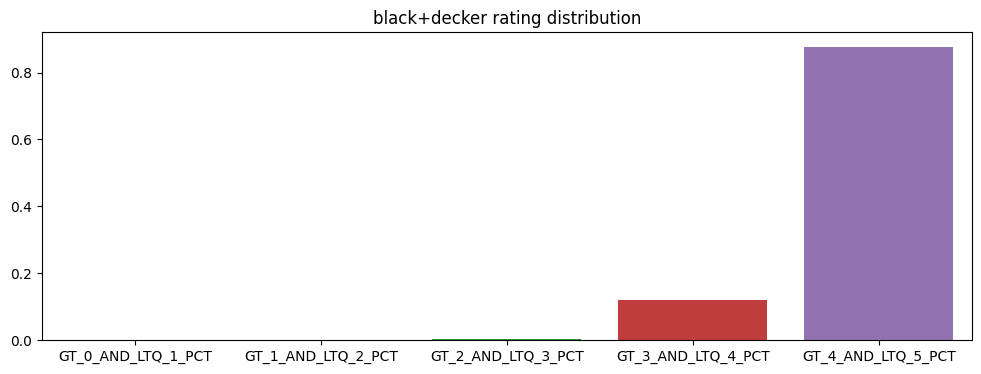

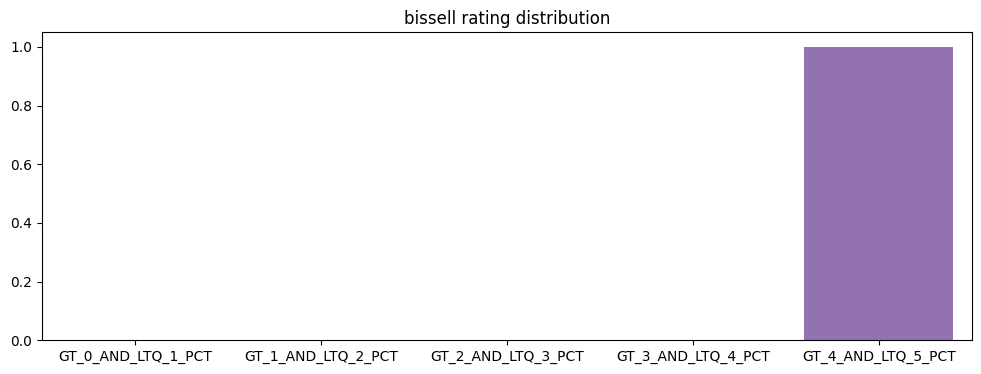

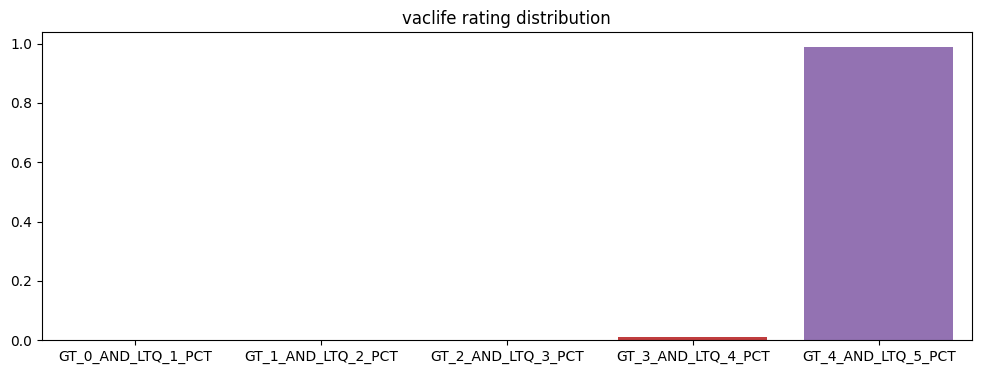

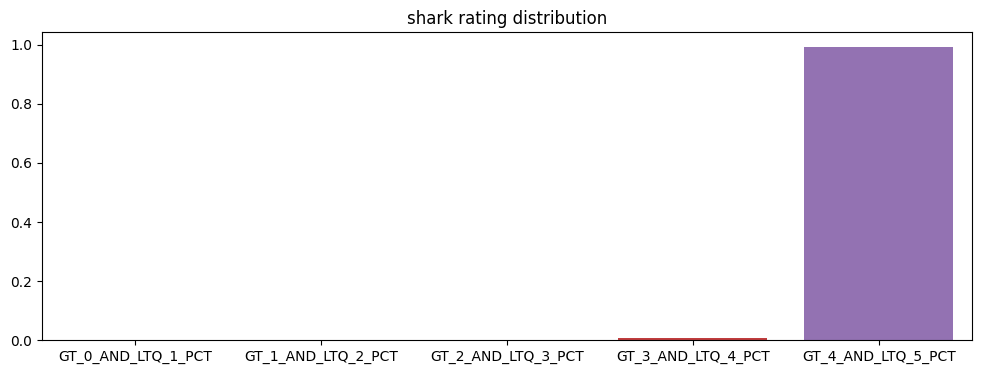

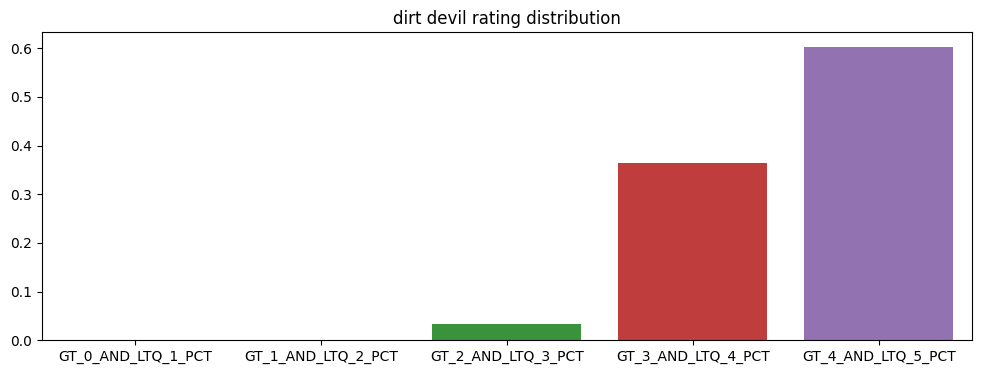

,brand,ci,sample_size,est_mean,est_lower_limit,est_pper_limit
0,black+decker,0.95,10000,4.332993,4.327688,4.338299
1,bissell,0.95,10000,4.333167,4.327857,4.338477
2,vaclife,0.95,10000,4.330776,4.325349,4.336204
3,shark,0.95,10000,4.331206,4.325835,4.336577
4,dirt devil,0.95,10000,4.332513,4.327127,4.337900


In [38]:
estimate_list = []
sample_size_1 = 1000
sample_size_2 = 10000
sample_size_3 = 100000
ci = 0.95
ci_list = []
for brand in top_5_brands:
    test_df =  df_top5_bramd_product_rating_stats[(df_top5_bramd_product_rating_stats.BRAND == brand)].sample(frac=1).reset_index(drop=True)[['GT_0_AND_LTQ_1_PCT', 'GT_1_AND_LTQ_2_PCT', 'GT_2_AND_LTQ_3_PCT', 'GT_3_AND_LTQ_4_PCT', 'GT_4_AND_LTQ_5_PCT']]
    plt.figure(figsize = (12,4))
    plt.title(f"{brand} rating distribution")
    sns.barplot(test_df)
    plt.show(block = False)
    test_df = df_top5.sample(frac=1).reset_index(drop=True)[['PRODUCTRATING']].sample(n = sample_size_2, replace = True, random_state = 1000)
    #print(st.norm.interval(ci, loc=np.nanmean(test_df), scale=st.sem(test_df, nan_policy='omit')))
    est_mean = np.nanmean(test_df)
    lower_limit = st.t.interval(ci, len(test_df)-1, loc=np.nanmean(test_df), scale=st.sem(test_df, nan_policy='omit'))[0][0]
    upper_limit = st.t.interval(ci, len(test_df)-1, loc=np.nanmean(test_df), scale=st.sem(test_df, nan_policy='omit'))[1][0]
    #lower_limit = st.norm.interval(ci, loc=np.mean(test_df), scale=st.sem(test_df))[0][0]
    #upper_limit = st.norm.interval(ci, loc=np.mean(test_df), scale=st.sem(test_df))[1][0]
    ci_list.append((brand, ci, sample_size_2, np.nanmean(test_df), lower_limit, upper_limit))
df_ci = pd.DataFrame(ci_list, columns = ['brand', 'ci', 'sample_size', 'est_mean', 'est_lower_limit', 'est_pper_limit'])
df_ci

In [39]:
#sample_size = sample_size_2
pct_columns = ['GT_0_AND_LTQ_1_PCT', 'GT_1_AND_LTQ_2_PCT', 'GT_2_AND_LTQ_3_PCT', 'GT_3_AND_LTQ_4_PCT', 'GT_4_AND_LTQ_5_PCT']
for brand_idx, brand in enumerate(top_5_brands):#df_review['BRAND'].drop_duplicates().values.tolist():
    print(brand)
    brand_rating_dist = df_top5_bramd_product_rating_stats[df_top5_bramd_product_rating_stats.BRAND == brand][pct_columns].values[0]
    brand_ratig_bin_dist = np.round(brand_rating_dist * sample_size_1).astype(int)
    for i in range(sample_size_2):
        #print(brand, i)
        agg_temp_df = pd.DataFrame()
        temp_df = pd.DataFrame()
        for bin_idx, bin in enumerate(['GT_0_AND_LTQ_1', 'GT_1_AND_LTQ_2', 'GT_2_AND_LTQ_3', 'GT_3_AND_LTQ_4', 'GT_4_AND_LTQ_5']):
            temp_df = df_top5[(df_top5.BRAND == brand) & (df_top5.PRODUCTRATING_BIN == bin)].sample(frac=1).reset_index(drop=True)[['PRODUCTRATING', 'PRODUCTRATING_BIN']].sample(n = brand_ratig_bin_dist[bin_idx], replace = True, random_state = i + bin_idx + 1 + brand_idx + 1)
            agg_temp_df = pd.concat([agg_temp_df, temp_df], ignore_index=True)
        #print(len(agg_temp_df))
        estimate = agg_temp_df['PRODUCTRATING'].mean()
        estimate_list.append((brand, estimate))
df_estimate = pd.DataFrame(estimate_list)
df_estimate.columns = ['BRAND', 'ESTIMATED_SAMPLE_MEAN']
df_estimate

black+decker
bissell
vaclife
shark
dirt devil


,BRAND,ESTIMATED_SAMPLE_MEAN
0,black+decker,4.293000
1,black+decker,4.289500
2,black+decker,4.290600
3,black+decker,4.283400
4,black+decker,4.280800
...,...,...
49995,dirt devil,4.021622
49996,dirt devil,4.029830
49997,dirt devil,4.014014
49998,dirt devil,4.020120


In [40]:
df_estimate.groupby(['BRAND']).agg({"ESTIMATED_SAMPLE_MEAN" : [np.mean, np.std]})

ESTIMATED_SAMPLE_MEAN          
                              mean       std
BRAND                                       
bissell                   4.446895  0.004475
black+decker              4.289700  0.004407
dirt devil                4.024866  0.007667
shark                     4.472695  0.004597
vaclife                   4.268775  0.002792

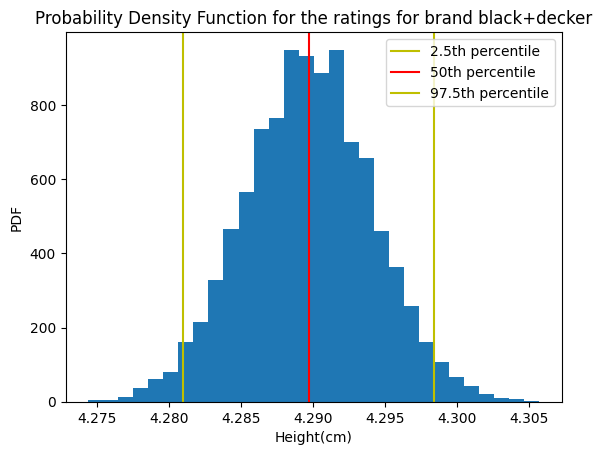

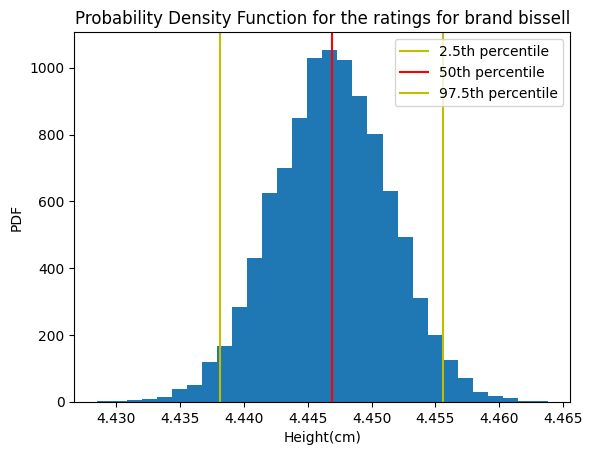

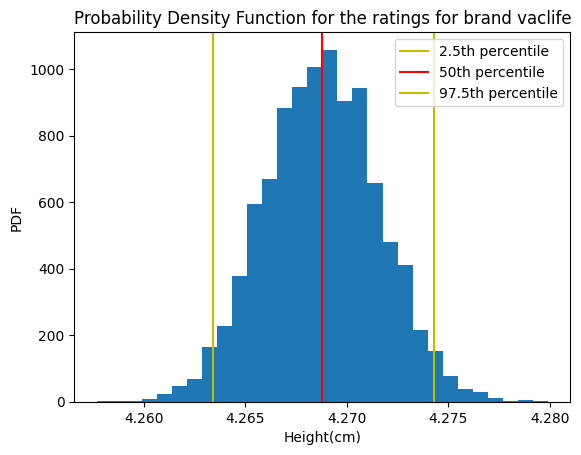

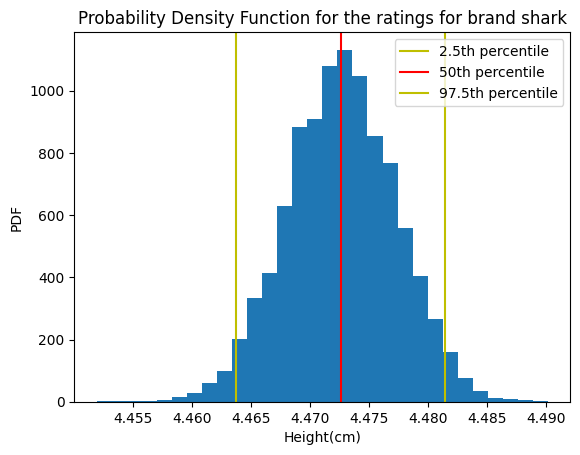

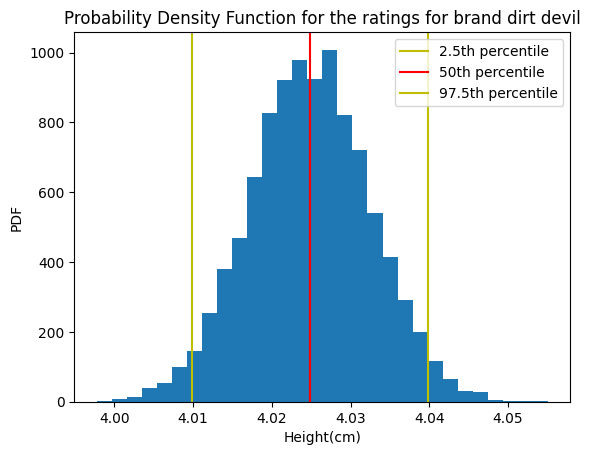

In [53]:
for brand in top_5_brands:
    plt.hist(df_estimate[df_estimate.BRAND == brand]['ESTIMATED_SAMPLE_MEAN'],bins=30)

    # Showing the related percentiles
    plt.axvline(x=np.percentile(df_estimate[df_estimate.BRAND == brand]['ESTIMATED_SAMPLE_MEAN'],[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
    plt.axvline(x=np.percentile(df_estimate[df_estimate.BRAND == brand]['ESTIMATED_SAMPLE_MEAN'],[50.0]), ymin=0, ymax=1,label='50th percentile',c='r')
    plt.axvline(x=np.percentile(df_estimate[df_estimate.BRAND == brand]['ESTIMATED_SAMPLE_MEAN'],[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='y')

    plt.xlabel("Height(cm)")
    plt.ylabel("PDF")
    plt.title(f"Probability Density Function for the ratings for brand {brand}")
    plt.legend()
    plt.show(block = False)

In [43]:
np.percentile(df_estimate[df_estimate.BRAND == brand]['ESTIMATED_SAMPLE_MEAN'],[2.5,97.5])

array([4.00980981, 4.03983984])

In [41]:
df_ci

,brand,ci,sample_size,est_mean,est_lower_limit,est_pper_limit
0,black+decker,0.95,10000,4.332993,4.327688,4.338299
1,bissell,0.95,10000,4.333167,4.327857,4.338477
2,vaclife,0.95,10000,4.330776,4.325349,4.336204
3,shark,0.95,10000,4.331206,4.325835,4.336577
4,dirt devil,0.95,10000,4.332513,4.327127,4.337900


In [42]:
df_review_stats[df_review_stats.brand.isin(top_5_brands)]

,brand,avg_rating,rating_std,rating_count
7,bissell,4.446835,0.142636,39588
8,black+decker,4.290583,0.303297,61116
17,dirt devil,4.024465,0.493552,12201
54,shark,4.472516,0.153798,24451
63,vaclife,4.268578,0.098100,28922


In [22]:
#brand_review_list = []

In [23]:
#tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

#model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [24]:
'''
df_review_sentiment = pd.DataFrame()
temp_df = pd.DataFrame()
for brand in top_5_brands:#df_review['BRAND'].drop_duplicates().values.tolist():
    temp_df = df_review[df_review.BRAND == brand][['BRAND','REVIEW_TEXT']]
    print(f"Brand: {brand}")
    print(f"Number of reviews: {len(temp_df)}")
    for i in list(list(range(0, len(temp_df), 1000))):
        print(i)
        temp_df['REVIEW_TEXT_SENTIMENT'] = temp_df.iloc[i : i + 1000, :]['REVIEW_TEXT'].apply(lambda x: get_sentiment_score(x[:512]))
        df_review_sentiment = pd.concat([df_review_sentiment, temp_df], ignore_index=True)
    temp_df = pd.DataFrame()
'''

'\ndf_review_sentiment = pd.DataFrame()\ntemp_df = pd.DataFrame()\nfor brand in top_5_brands:#df_review[\'BRAND\'].drop_duplicates().values.tolist():\n    temp_df = df_review[df_review.BRAND == brand][[\'BRAND\',\'REVIEW_TEXT\']]\n    print(f"Brand: {brand}")\n    print(f"Number of reviews: {len(temp_df)}")\n    for i in list(list(range(0, len(temp_df), 1000))):\n        print(i)\n        temp_df[\'REVIEW_TEXT_SENTIMENT\'] = temp_df.iloc[i : i + 1000, :][\'REVIEW_TEXT\'].apply(lambda x: get_sentiment_score(x[:512]))\n        df_review_sentiment = pd.concat([df_review_sentiment, temp_df], ignore_index=True)\n    temp_df = pd.DataFrame()\n'

In [25]:
#df_review_sentiment

In [26]:
#df_review['REVIEW_TEXT_SENTIMENT'] = df_review['REVIEW_TEXT'].apply(lambda x: sentiment_score(x[:512]))

In [27]:
'''
tokens = tokenizer.encode("good 😄", return_tensors='pt')
result = model(tokens)
int(torch.argmax(result.logits))+1
'''

'\ntokens = tokenizer.encode("good 😄", return_tensors=\'pt\')\nresult = model(tokens)\nint(torch.argmax(result.logits))+1\n'